# **41079 Computer Science Studio 2**
## *Notebook 1: Dataset Preprocessing*

---
## **1. Introduction & Set Up**

#### **1.1. Import Necessary Libaries/Packages**

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
from huggingface_hub import login
from datasets import load_dataset, DatasetDict, concatenate_datasets
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from BERTweet.TweetNormalizer import normalizeTweet
import os

#### **1.2. Define Constants**

In [2]:
DATA_DIR = "./data/tweet_eval"
os.makedirs(DATA_DIR, exist_ok=True)

# Paths to expected CSV files
SPLIT_PATHS = {
    "raw_train": os.path.join(DATA_DIR, "raw_train.csv"),
    "raw_test": os.path.join(DATA_DIR, "raw_test.csv"),
    "raw_validation": os.path.join(DATA_DIR, "raw_validation.csv"),

    "train": os.path.join(DATA_DIR, "train.csv"),
    "test": os.path.join(DATA_DIR, "test.csv"),
    "validation": os.path.join(DATA_DIR, "validation.csv")
}

#### **1.3. Load Dataset**

log into hugging face :D

In [4]:
# Download from Hugging Face only if raw files are missing
if all(os.path.exists(path) for path in [SPLIT_PATHS["raw_train"], SPLIT_PATHS["raw_test"], SPLIT_PATHS["raw_validation"]]):
    print("Loading TweetEval raw dataset from local files...")
    raw_dataset = load_dataset("csv", data_files={
        "train": SPLIT_PATHS["raw_train"],
        "test": SPLIT_PATHS["raw_test"],
        "validation": SPLIT_PATHS["raw_validation"]
    })
else:
    print("Downloading TweetEval dataset from Hugging Face...")
    raw_dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")
    print("Saving raw TweetEval dataset for future use...")
    raw_dataset["train"].to_csv(SPLIT_PATHS["raw_train"], index=False)
    raw_dataset["test"].to_csv(SPLIT_PATHS["raw_test"], index=False)
    raw_dataset["validation"].to_csv(SPLIT_PATHS["raw_validation"], index=False)

Loading TweetEval raw dataset from local files...


#### **1.4. Clean Dataset**

In [5]:
# If cleaned CSVs already exist, load those, otherwise clean the data and save for future use
if all(os.path.exists(SPLIT_PATHS[split]) for split in ["train", "test", "validation"]):
    print("Loading Cleaned Dataset from Local CSV Files...")
    cleaned_dataset_dict = load_dataset("csv", data_files={
        "train": SPLIT_PATHS["train"],
        "test": SPLIT_PATHS["test"],
        "validation": SPLIT_PATHS["validation"]
    })
else:
    print("Cleaning Raw Dataset from Local CSV Files...")

    # Load raw dataset
    raw_dataset = load_dataset("csv", data_files={
        "train": SPLIT_PATHS["raw_train"],
        "test": SPLIT_PATHS["raw_test"],
        "validation": SPLIT_PATHS["raw_validation"]
    })
    # Define basic unicode cleaning
    def decode_unicode_escapes(example):
        try:
            example["text"] = example["text"].encode("utf-8").decode("unicode_escape")
        except UnicodeDecodeError:
            pass  # leave unchanged if decode fails to process text
        return example

    # Clean and save
    cleaned_dataset = raw_dataset.map(decode_unicode_escapes)

    print("Saving Cleaned Dataset to Disk...")
    cleaned_dataset["train"].to_csv(SPLIT_PATHS["train"], index=False)
    cleaned_dataset["test"].to_csv(SPLIT_PATHS["test"], index=False)
    cleaned_dataset["validation"].to_csv(SPLIT_PATHS["validation"], index=False)

    cleaned_dataset_dict = cleaned_dataset

Loading Cleaned Dataset from Local CSV Files...


In [6]:
# Add human-readable sentiment labels
label_to_sentiment = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

def add_sentiment_label(example):
    example["sentiment"] = label_to_sentiment.get(example["label"], "unknown")
    return example

cleaned_dataset_dict["train"] = cleaned_dataset_dict["train"].map(add_sentiment_label)
cleaned_dataset_dict["test"] = cleaned_dataset_dict["test"].map(add_sentiment_label)
cleaned_dataset_dict["validation"] = cleaned_dataset_dict["validation"].map(add_sentiment_label)

#### **1.5. Cache Dataset**

In [7]:
# Access individual splits
train_set = cleaned_dataset_dict["train"]
test_set = cleaned_dataset_dict["test"]
validation_set = cleaned_dataset_dict["validation"]

# Combine for full dataframe conversion
combined_dataset = concatenate_datasets([train_set, test_set, validation_set])
combined_dataset_df = combined_dataset.to_pandas()
combined_dataset_df.head(8)

,text,label,sentiment
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive
5,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive
6,""""""""""" SOUL TRAIN"""""""" OCT 27 HALLOWEEN SPECIAL ...",2,positive
7,So disappointed in wwe summerslam! I want to s...,0,negative


---
## **2. Exploratory Data Analysis**

#### **2.1. Visualise Label Distribution**

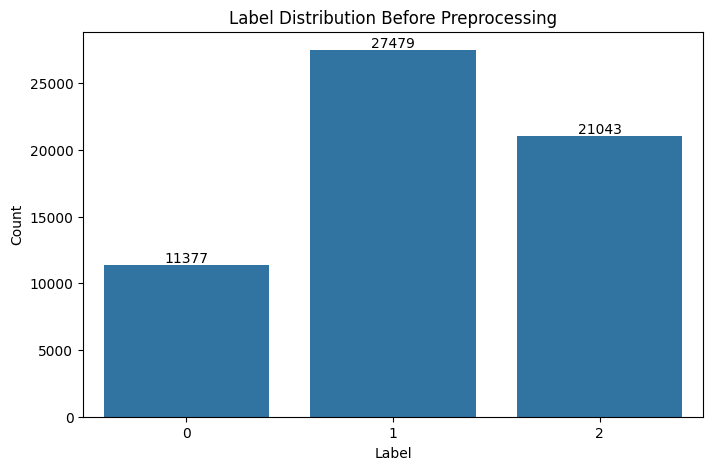

In [8]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=combined_dataset_df)
plt.title('Label Distribution Before Preprocessing')
plt.xlabel('Label')
plt.ylabel('Count')

# Annotate each bar with count
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            f'{int(height)}', ha='center', va='bottom')

plt.show()

#### **2.2. Null & Duplicate Entry Check**

In [9]:
# Count and display null values
null_counts = combined_dataset_df.isnull().sum()
print("Number of null values:\n", null_counts)

# Drop null entries
combined_dataset_df = combined_dataset_df.dropna()

# Remove whitespace-only entries
combined_dataset_df = combined_dataset_df[combined_dataset_df['text'].str.strip().astype(bool)]

# Remove duplicate texts
combined_dataset_df = combined_dataset_df.drop_duplicates(subset=['text'])

# View updated dataset size
print(f"Cleaned dataset shape: {combined_dataset_df.shape}")

Number of null values:
 text         0
label        0
sentiment    0
dtype: int64
Cleaned dataset shape: (59870, 3)


---
## **3. Visualisations**

#### **3.1. Function for Word Cloud Generation with Optional Filtering**

In [10]:
def generate_wordcloud(data, label=None, title=None, width=800, height=800, full_size=False):
    # Remove @user placeholders for cleaner visualisation
    df = data.copy()
    df['text'] = df['text'].str.replace(r'@user', '', regex=True).str.strip()

    # Filter if label is specified
    if label is not None:
        df = df[df['label'] == label]
    
    # Combine all text into one string
    text_corpus = ' '.join(df['text'].tolist())

    # Generate word cloud
    wordcloud = WordCloud(width=width, height=height, background_color='white', min_font_size=10).generate(text_corpus)

    # Plot
    if(full_size):
        plt.figure(figsize=(width / 100, height / 100))
    else:
        plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    if title:
        plt.title(title)
    elif label is not None:
        sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
        plt.title(f"Common {sentiment_map.get(label, 'Label ' + str(label))} Terms in the Dataset")
    else:
        plt.title("Common Terms in the Dataset")
    plt.axis("off")
    plt.show()

#### **3.2. Word Cloud for Common Terms Across All Labels**

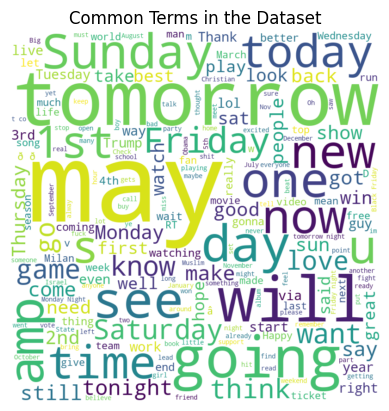

In [92]:
generate_wordcloud(combined_dataset_df)

#### **3.3. Word Clouds for Each Label**

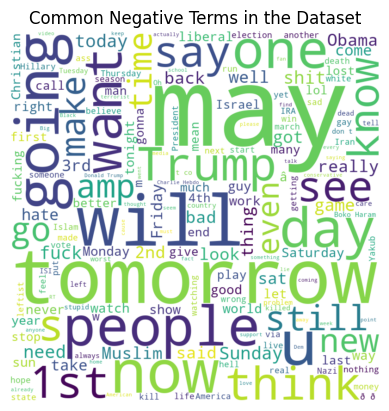

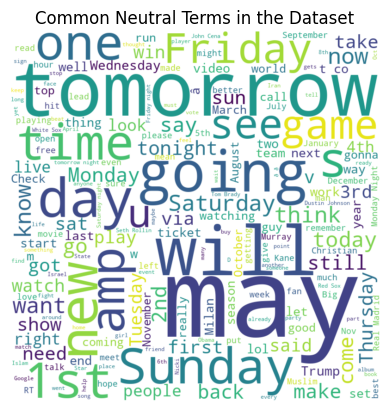

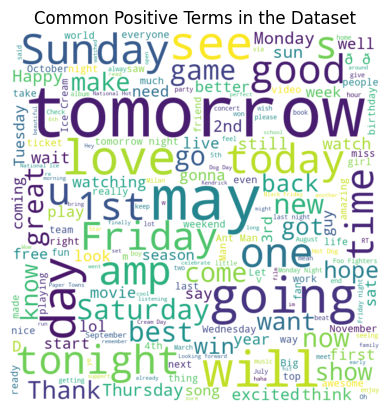

In [93]:
generate_wordcloud(combined_dataset_df, 0)
generate_wordcloud(combined_dataset_df, 1)
generate_wordcloud(combined_dataset_df, 2)

---
## **4. Text Normalisation**

In [11]:
# Convert to string (in case of NaNs or numerical noise)
combined_dataset_df['text'] = combined_dataset_df['text'].astype(str)

# Apply TweetNormalizer from BERTweet
combined_dataset_df['text'] = combined_dataset_df['text'].apply(normalizeTweet)

---
## **5. Create Train-Test Split**

#### **5.1. Stratified Split**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_dataset_df['text'],
    combined_dataset_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=combined_dataset_df['label']
)

#### **5.2. Convert to DataFrames**

In [13]:
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

#### **5.3. Export for Model Training**

In [14]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Preprocessed Training and Testing data saved successfully.")

Preprocessed Training and Testing data saved successfully.
